<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S64_driving_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# %pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [1]:
import math
import numpy as np
import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam 
from gtbook import driving
from gtbook.display import show

# PoseSLAM
> PoseSLAM is SLAM with pose priors and relative pose constraints only.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [2]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(6, 4, "steampunk", 1))

## Iterative Closest Points

> ICP is a seminal method to align 2 point clouds.

**Iterative closest points** or **ICP** is a method to align two point clouds, e.g., two successive LIDAR scans. Let us use superscripts $a$ and $b$ to distinguish the two point clouds, and the points therein. Under the assumption that we have a good initial estimate $\hat{T^a_b}$ for the relative pose $T^a_b$ between the two point clouds, we iterate between two steps:

- find closest point correspondences between the two clouds;
- re-estimate the relative pose $\hat{T^a_b}$ between the two clouds.

These two steps are iterated until convergence, hence the name. Below we  explain both steps in order.

### Finding Closest Points

The first step is the easiest: for each point $P^a_j$ in the first point cloud, find the closest point $P^b_j$ in the second point cloud. Stated formally we have:

$$
P^b_j = \arg \min_{P^b} \| P^b - P^a_j\|^2
$$

where minimizing the square is just as good as minimizing the distance, because they are monotonically related. This is known as the **nearest neighbor** problem, and doing so for all points is the **all nearest neighbors** problem.

The brute force algorithm of iterating over all points in the second cloud can be quite slow, and indeed finding all nearest neighbors that way has quadratic complexity. However, very fast *approximate* nearest neighbor algorithms are available. Many of these use specialized data structures, such as "KD-trees" or "Oct-trees" (in 3D). While the details are out of scope, intuitively these data structures  recursively divide up the point clouds into sub-clouds, such that sub-clouds unlikely to contain the nearest neighbor can be quickly excluded. We build his data structure ones for the beat second cloud, and then use it for all nearest neighbor searches, leading to complexity which is approximately $O(N \log N$).

### Estimating the Pairwise Transform

The second step is the more interesting one: given a set of closest point pairs $(P^a_j, P^b_j)$, how can we estimate from those the relative pose $\widehat{T^a_b}$ between two points clouds? This is known as the **pose alignment** problem.

Let us first assume that the two point clouds only differ by a rotation $R^a_b$. When this is the case, and assuming we have corresponding points $P^a$ and $P^b$, then each point $P^a$ in the first cloud can be expressed as a function of a point $P^b$ in the second cloud:

$$
P^a = R^a_b P^b
$$

One might be tempted to think that therefore 

$$
R^a_b = P^a (P^b)^T
$$

but that is just silly (think about why!). Interestingly, though, if we form the matrix

$$
H = \sum_j P^a_j (P^b_j)^T
$$

by summing over at least 3 point pairs $(P^a_j, P^b_j)$, it turns out that the rotation matrix $\widehat{R^a_b}$ closest to $H$ in the least squares sense *is* the best possible estimate for the unknown rotation $R^a_b$. In addition, using the *singular value decomposition* $H=U\Lambda V^T$ from linear algebra, it is *very* easy to compute:

$$
\widehat{R^a_b} = U V^T
$$

Interesting aside: this problem is known as the *orthogonal Procrustes problem* and its solution via SVD been known since 1966, from a paper by Peter Schönemann in a *psychology* journal.

The above solves the problem when there is only rotation, but it turns out that the best possible translation estimate will always align both *centroids* of the point clouds. Hence, when there is translation present, we simply compute the matrix $H$ from the *centered* points, 

$$
H = \sum_j (P^a_j-C^a) (P^b_j-C^b)^T
$$

where the point cloud centroids $C^a$ and $C^b$ are computed as 
$$
C^a = \frac{1}{N} \sum_j P^a_j\text{  and  }C^b = \frac{1}{N} \sum_j P^b_j.
$$

Given the estimated rotation $\widehat{R^a_b}$, the translation estimate $\widehat{t^a_b}$ can be estimated from 

$$
C^a = \widehat{R^a_b} C^b + \widehat{t^a_b},
$$

and the final relative pose estimate is given by $\widehat{T^a_b} =(\widehat{R^a_b}, \widehat{t^a_b})$. By the way, all of the above math is identical for both the 2D and 3D case.

## SLAM

> SLAM is Simultaneous Localization and Mapping.

**SLAM** is **Simultaneous Localization and Mapping**. In the SLAM
problem the goal is to localize a robot using the information coming
from the robot’s sensors. The additional wrinkle in SLAM is that we do
*not* know the map a priori, and hence we have to infer the unknown map
simultaneously with localization with respect to the evolving map.

**PoseSLAM** is a variant of SLAM that uses pose constraints as the
basic building block, and where we optimize over the unknown vehicles
poses. We do not explicitly optimize over a map: that is reconstructed
after the fact.

To represent the pose of a vehicle, recall that 2D poses
$T\doteq(x,y,\theta)$ form the Special Euclidean group $SE(2)$, and
can be represented by $3\times3$ matrix of the form
$$
T=\left[\begin{array}{cc|c}
\cos\theta & -\sin\theta & x\\
sin\theta & \cos\theta & y\\
\hline 0 & 0 & 1
\end{array}\right]=\left[\begin{array}{cc}
R & t\\
0 & 1
\end{array}\right]
$$
with the $2\times1$ vector $t$
representing the position of the vehicle, and $R$ the $2\times2$
rotation matrix representing the vehicle’s orientation in the plane.

Note that this representation generalizes equally to three dimensions,
but of course $t$ will be a three-vector, and $R$ will be a $3\times3$
rotation matrix representing the 3DOF attitude of the vehicle. The
latter can be decomposed into roll, pitch, and yaw, if so desired.

The PoseSLAM problem is then:

> given a set of noisy relative measurements or **pose constraints**
> $\tilde{T}_{ij}$, recover the optimal set of poses $T_{i}^{*}$ that
> maximizes the posteriori probability, i.e., recover the MAP solution.

In the case of mapping for autonomous driving, these relative
measurements can be derived from performing ICP between overlapping
scans. We can use GPS and/or IMU measurements to decide which scans
overlap, so that we do not have to compare $O(n^{2})$ scans. Depending
on the situation, we can optimize for 3D or 2D poses, in the way we will
discus below. Afterwards, we can reconstruct a detailed map by
transforming the local LIDAR scans into the world frame, using the
optimized poses $T_{i}^{*}$.

## The PoseSLAM Factor Graph

In our factor-graph-based view of the world, a pose constraint is
represented as a factor. As before, the factor graph represent the
posterior distribution over the unknown pose variables
$\mathcal{T}=\{X_{1}\dots X_{5}\}$ given the known measurements:

$$
\phi(\mathcal{T})=\prod_{i}\phi_{i}(\mathcal{T}_{i}).
$$

The factor graph encodes which factors are connected to which variables,
exposing the sparsity pattern of the corresponding estimation problem.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures6/PoseSLAM-FG.png?raw=1" id="fig:PoseSLAMFG" style="width:60.0%" /><figcaption><span id="fig:PoseSLAMFG" label="fig:PoseSLAMFG">[fig:PoseSLAMFG]</span> PoseSLAM factor graph example.</figcaption>
</figure>

An example is shown in Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>.
The example represents a vehicle driving around, and taking LIDAR scans
at 5 different world poses, represented by $T_{1}$ to $T_{5}$.
The factors $f_{1}$ to $f_{4}$ are binary factors representing the pose
constraints obtained by matching successive LIDAR scans. The factor
$f_{5}(T_{5},T_{2})$ is a so-called “loop closure” constraint:
rather than derived from two successive scans, this one is derived from
matching the scan taken at $T_{5}$ with the one at $T_{2}$.
Detecting such loops can be done through a variety of means. The final,
unary factor $f_{0}(T_{1})$ is there to “anchor” the solution to the
origin: if it is not there, the solution will be undetermined. Another
way to anchor the solution is to add unary factors at every time-step,
derived from GPS.
Finding the MAP in the case that variables are continuous and
measurements are linear combinations of them can be done via
least-squares. Above we have discussed MAP inference for discrete
variables, and we have discussed probability distributions for
continuous variables, but we have never put the two together. In the
case of measurements corrupted by zero-mean Gaussian noise, we can
recover the MAP solution by minimization. Recall that a multivariate
Gaussian density **with mean** $\mu$ and **variance** $\sigma^{2}$ is
given by

$$
\mathcal{N} x\mu\sigma^2=\frac{1}{\sqrt{2\pi\sigma^{2}}}\exp\left\{ -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{2}\right\} .
$$

If we focus our attention in PoseSLAM on just the x coordinates, then we
predict relative measurements $\tilde{x}_{ij}$ by

$$
\tilde{x}_{ij}\approx h(x_{i,}x_{j})=x_{j}-x_{i}
$$
 and each factor in
Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>
could be written as

$$
\phi(x_{i},x_{j})=\frac{1}{\sqrt{2\pi}}\exp\left\{ -\frac{1}{2}\left(x_{j}-x_{i}-\tilde{x}_{ij}\right)^{2}\right\} ,
$$

where we assumed $\sigma=1$ for now. By taking the negative log,
maximizing the posterior corresponds to minimizing the following sum of
squares, where sum ranges over all $(i,j)$ pairs for which we have a
pairwise measurement:

$$
\mathcal{X}^{*}=\arg\min_{\mathcal{X}}\sum_{k}\frac{1}{2}\left(h(x_{i},x_{j})-\tilde{x}_{ij}\right)^{2}=\arg\min_{\mathcal{X}}\sum_{k}\frac{1}{2}\left(x_{j}-x_{i}-\tilde{x}_{ij}\right)^{2}.
$$

Linear least squares problems like these are easily solved by numerical
computing packages like MATLAB or numpy.

Unfortunately, in the PoseSLAM case we cannot use linear least squares,
because poses are not simply vectors, and the measurements are not
simply linear functions of the poses. Indeed, in PoseSLAM both the
prediction $h(T_{i},T_{j})$ and the measurement $\tilde{T}_{ij}$
are relative poses. The measurement prediction function $h(.)$ is given
by 
$$
h(T_{i},T_{j})=T_{i}^{-1}T_{j}
$$
 and the
measurement error to be minimized is

$$
\frac{1}{2}\left\Vert \log\left(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j}\right)\right\Vert ^{2}
$$

where $\log:SE(2)\rightarrow\mathbb{R}^3$ denotes a map from $SE(2)$ to a
three-dimensional local coordinate vector $\xi$, which will be defined
in detail below.

## Nonlinear Optimization for PoseSLAM

There are two ways out of the nonlinear quandary. The first is to
realize that the only non-linearities stem from the $\sin$ and $\cos$
terms in the poses, associated with the unknown orientations
$\theta_{i}$. Hence, one solution is to try and solve for the
orientations first, and then solve for the translations using linear
least squares, exactly as above. This approach is known as **rotation
averaging** followed by linear translation recovery. Unfortunately it is
sub-optimal as it does not consider the orientation and translation
simultaneously. However, it can serve to provide a (very) good initial
estimate for nonlinear optimization, discussed below.

Indeed, we will prefer to take a second route, which is to use
**nonlinear optimization**. As discussed, the error expressions
(<a href="#eq:logmap" data-reference-type="ref" data-reference="eq:logmap">[eq:logmap]</a>)
are *nonlinear*, and we cannot directly optimize over the poses
$T_{i}$. Instead, we will locally linearize the problem and solve
the corresponding linear problem using least-squares, and iterate this
until convergence. We do this by, at each iteration, parameterizing a
pose $T$ by 
$$
T\approx\bar{T}\Delta(\xi)
$$

where $\xi$ are 3D local coordinates
$\xi\doteq(\delta x,\delta y,\delta\theta)$ and the incremental pose
$\Delta(\xi)\in SE(2)$ is defined as

$$
\Delta(\xi)=\left[\begin{array}{cc|c}
1 & -\delta\theta & \delta x\\
\delta\theta & 1 & \delta y\\
\hline 0 & 0 & 1
\end{array}\right]
$$
 which you can recognize as a small angle
approximation of the $SE(2)$ matrix
(<a href="#eq:SE2-matrix" data-reference-type="ref" data-reference="eq:SE2-matrix">[eq:SE2-matrix]</a>).
In 3D the local coordinates $\xi$ are 6-dimensional, and the small angle
approximation is defined as 
$$
\Delta(\xi)=\left[\begin{array}{ccc|c}
1 & -\delta\theta_{z} & \delta\theta_{y} & \delta x\\
\delta\theta_{z} & 1 & -\delta\theta_{x} & \delta y\\
-\delta\theta_{y} & \delta\theta_{x} & 1 & \delta z\\
\hline 0 & 0 & 0 & 1
\end{array}\right]
$$
 With this new notation, we can approximate the
nonlinear error
(<a href="#eq:logmap" data-reference-type="ref" data-reference="eq:logmap">[eq:logmap]</a>)
by a linear approximation:


$$
\frac{1}{2}\left\Vert \log\left(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j}\right)\right\Vert ^{2}\approx\frac{1}{2}\left\Vert A_{i}\xi_{i}+A_{j}\xi_{j}-b\right\Vert ^{2}.
$$

For $SE(2)$ the matrices $A_{i}$ and $A_{j}$ are the $3\times3$ **or
Jacobian matrices** and $b$ is a $3\times1$ bias term. The above
provides a linear approximation of the term within the norm as a
function of the incremental local coordinates $\xi_{i}$ and $\xi_{j}$.
Deriving the detailed expressions for these Jacobians is beyond the
scope of this document, but suffice to say that they exist and not too
expensive to compute. In three dimensions, the Jacobian matrices are
$6\times6$ and $16\times6$, respectively.

The final optimization will—in each iteration—minimize over the local
coordinates of all poses by summing over all pose constraints. If we
index those constraints by $k$, we have the following least squares
problem:

$$
\Xi^{*}=\arg\min_{\Xi}\sum_{k}\frac{1}{2}\Vert A_{ki}\xi_{i}+A_{kj}\xi_{j}-b_{k}\Vert ^{2}
$$

where $\Xi\doteq \{  \xi_{i}\}$, the set
of all incremental pose coordinates.

After solving for the incremental updates $\Xi$, we update all poses
using equation
<a href="#eq:update" data-reference-type="ref" data-reference="eq:update">[eq:update]</a>
and check for convergence. If the error does not decrease significantly
we terminate, otherwise we linearize and solve again, until the error
converges. While this is not guaranteed to converge to a global minimum,
in practice it does so if there are enough relative measurements and a
good initial estimate is available. For example, GPS can provide us with
a good initial estimate. However, especially in urban environments GPS
can be quite noisy, and it could happen that the map quality suffers by
converging to a bad local minimum. Hence, a good quality control process
is absolutely necessary in production environments.

For SLAM we typically use specializes packages such as G2O, Ceres, or
GTSAM that exploit the sparsity of the factor graphs to dramatically
speed up computation. Note that MATLAB and/or numpy can solve sparse
least squares problems: the specialized SLAM packages simply provide the
translation as well as the calculation of the Jacobian matrices above.

In summary, the algorithm for nonlinear optimization is

-   Start with an initial estimate $\mathcal{T}^{0}$

-   Iterate:

    1.  Linearize the factors
$\frac{1}{2}\Vert \log(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j})\Vert ^{2}\approx\frac{1}{2}\Vert A_{i}\xi_{i}+A_{j}\xi_{j}-b\Vert ^{2}$

    2.  Solve the least squares problem
        $\Xi^{*}=\arg\min_{\Xi}\sum_{k}\frac{1}{2}\Vert A_{ki}\xi_{i}+A_{kj}\xi_{j}-b_{k}\Vert ^{2}$

    3.  Update $X_{i}^{t+1}\leftarrow X_{j}^{t}\Delta(\xi_{i})$

-   Until the nonlinear error
$J(\mathcal{T})\doteq\sum_{k}\frac{1}{2}\Vert \log(\tilde{T}_{ij}^{-1}T_{i}^{-1}T_{j})\Vert ^{2}$
    converges.

## The Variable Elimination Algorithm

There exists a general algorithm that, given *any* factor graph, can
compute the corresponding posterior distribution
$p(\mathcal{X}|\mathcal{Z})$ on the unknown variables $\mathcal{X}$.
Above we saw that a factor graph represents the unnormalized posterior
$\phi(\mathcal{X})\propto P(\mathcal{X}|\mathcal{Z})$ as a product of
factors, typically generated directly from the measurements. The
variable elimination algorithm is a general recipe for converting any
factor graph back to a Bayes net, but now *only* on the unknown
variables $\mathcal{X}$.

In particular, the **variable elimination** algorithm is a way to
factorize any factor graph of the form

$$\phi(\mathcal{X})=\phi(X_{1},\ldots,X_{n})$$ 

into a factored Bayes net
probability density of the form

$$p(\mathcal{X})=p(X_{1}|\mathcal{S}_{1})p(X_{2}|\mathcal{S}_{2})\ldots p(X_{n})=\prod_{j}p(X_{j}|\mathcal{S}_{j}),$$

where the **separator** $\mathcal{\mathcal{S}}(X_{j})$ is defined as the
set of variables on which $X_{j}$ is conditioned, after elimination.
While this factorization is akin to the chain rule, eliminating a sparse
factor graph will typically lead to small separators, although this
depends on the chosen variable ordering $X_{1},\ldots,X_{n}$.

The variable elimination algorithm is listed below,
where we again used the shorthand notation
$\Phi_{j:n}\doteq\phi(X_{j},\ldots,X_{n})$ to denote a partially
eliminated factor graph.

---
`Eliminate`($\Phi_{1:n}$):
Given a factor graph on $n$ variables, call `EliminateOne` below for all variables $X_j$, every time yielding a conditional $p(X_{j}|S_{j})$. Return the product of conditionals as the resulting Bayes net:

- For $j=1...n$:
  - $p(X_{j}|S_{j}),\Phi_{j+1:n}\gets \text{EliminateOne}(\Phi_{j:n},X_{j})$
- return $p(X_{1}|S_{1})p(X_{2}|S_{2})\ldots p(X_{n})$

`EliminateOne`($\Phi_{j:n},X_{j}$):
Eliminate variable $X_{j}$ from a factor graph $\Phi_{j:n}$:
- Remove all factors $\phi_{i}(\mathcal{X}_{i})$ that are
adjacent to $X_{j}$ 
- $\mathcal{S}(X_{j})$ $\gets$ all variables involved
excluding $X_{j}$
- $\psi(X_{j},S_{j})\gets\prod_{i}\phi_{i}(\mathcal{X}_{i})$
- $p(X_{j}|S_{j})\tau(S_{j})\gets\psi(X_{j},S_{j})$
- Add the new factor {$\tau(S_{j})$} back into the graph
- return $p(X_{j}|S_{j}),\Phi_{j+1:n}$
---

The algorithm proceeds by eliminating one
variable $X_{j}$ at a time, starting with the complete factor graph
$\Phi_{1:n}$. As we eliminate each variable $X_{j}$, the function
produces a single conditional $p(X_{j}|\mathcal{S}_{j})$, as well as a
reduced factor graph $\Phi_{j+1:n}$ on the remaining variables. After
all variables have been eliminated, the algorithm returns the resulting
Bayes net with the desired factorization.

Above we gave the sum-product version of the variable elimination
algorithm. The corresponding max-product version produces a DAG of
lookup tables instead, supporting the computation of the MPE. In both
cases, the complexity is similar but depends on the chosen variable
ordering $X_{1},\ldots,X_{n}$, as we discuss next.

## Complexity

The elimination algorithm has exponential complexity in the size of the
largest separator. The chosen variable ordering $X_{1},\ldots,X_{n}$ can
affect the complexity dramatically. Some orderings lead to smaller
separators, and unfortunately it is hard to find an optimal ordering -
although it can be done for small graphs. A good heuristic is to
greedily eliminate the variables with the smallest separator first.
Another is to recursively split the graph, and eliminate starting from
the leaves of the binary tree that is formed by the splitting process,
but we will not discuss that here.

In the special case of HMMs, and in fact any singly connected graph, the
complexity is linear in the number of nodes. The reason is easiest to
see for an HMM, as after conversion to a factor graph the graph is just
a chain. You can easily prove, by induction, that the size of the
separator is always one. It must be, by the way, as the resulting DAG is
also singly connected (there is at most one path from any node to any
other node). Algorithms
<a href="#alg:max-product-HMM" data-reference-type="ref" data-reference="alg:max-product-HMM">[alg:max-product-HMM]</a>
and
<a href="#alg:Sum-product-HMM" data-reference-type="ref" data-reference="alg:Sum-product-HMM">[alg:Sum-product-HMM]</a>
are the max-product and sum-product variants that we obtain when
eliminating from left to right. However, it is possible to choose a
different ordering, even for HMMs. For example, if we eliminate from
right to left, we get an equally efficient algorithm, although all the
intermediate product and marginal factors will be different.

### Exercises

1.  Perform symbolic elimination, i.e., just the graph part without
    computation, on some factor graphs of interest.

2.  Come up with an ordering for an HMM which is neither left-right or
    right-left which nevertheless results in a singly-connected Bayes
    net.

3.  Come up with an ordering to eliminate an HMM which does not lead to
    a singly-connected Bayes net.



## MAP Estimation

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/hmm-map-X3.png?raw=1" style="width:50.0%" alt="">
<figcaption>
<em>X</em><sub>1</sub></span>, respectively: we simply change the elimination order to make sure the variable(s) of interest are eliminated last.
</figcaption>
</figure>

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/hmm-map-1.png?raw=1" style="width:50.0%" alt="">
<figcaption>
<em>X</em><sub>1</sub></span>, respectively: we simply change the elimination order to make sure the variable(s) of interest are eliminated last.
</figcaption>
</figure>

Maximum a posteriori estimation is at least as expensive as MPE or
calculating the full posterior. Remember that MAP estimation is only
interested in a subset of the variables, and we partition the variables
into three sets: the variables of interest $\mathcal{X}$, the nuisance
variables $\mathcal{Y}$, and the observed variables $\mathcal{Z}$. The
elimination algorithm is easy to modify to do MAP estimation, simply *by
making sure that the variables of interest $\mathcal{X}$ are eliminated
last*.

Why does this work? We can easily see this if we take a “30,000 feet
view” of the elimination algorithm. In MAP estimation, we are interested
in maximizing $P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$, but the Bayes
net gives us the joint distribution
$P(\mathcal{X},\mathcal{Y},\mathcal{Z})$. The first step is to
instantiate the evidence $\mathfrak{z}$and convert to a factor graph
$f(\mathcal{X},\mathcal{Y};\mathcal{Z}=\mathfrak{z})$. When we eliminate
using the sum-product algorithm, using the elimination order
$\mathcal{Y},$$\mathcal{X}$, we obtain a DAG encoding the resulting
posterior as
$$P(\mathcal{Y}|\mathcal{X},\mathcal{Z}=\mathfrak{z})P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$$
where $P(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$ is the desired marginal
distribution on $\mathcal{X}$. Using max-product, the resulting DAG for
the MPE is
$$\pi(\mathcal{Y}|\mathcal{X},\mathcal{Z}=\mathfrak{z})\pi(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$$
where the lookup table $\pi(\mathcal{X}|\mathcal{Z}=\mathfrak{z})$
corresponds to the MAP estimate.

The higher complexity of MAP estimation derives from the fact that not
all elimination orderings are allowed anymore. In particular, the
optimal ordering, or even approximately optimal orderings, may all be
incompatible with eliminating $\mathcal{X}$ last.

### Exercises

1.  Do MAP estimation for some factor graphs of interest.

2.  Construct a small example where MAP estimation is more expensive
    than MPE, even when using optimal orderings for both.

3.  Think about the complexity of MAP estimation in an HMM. When is it
    not more expensive than MPE?



## Optimization with GTSAM

GTSAM exploits sparsity to be computationally efficient. Typically
measurements only provide information on the relationship between a
handful of variables, and hence the resulting factor graph will be
sparsely connected. This is exploited by the algorithms implemented in
GTSAM to reduce computational complexity. Even when graphs are too dense
to be handled efficiently by direct methods, GTSAM provides iterative
methods that are quite efficient regardless.

The following code, included in GTSAM as an example, creates the
factor graph from Figure
<a href="#fig:PoseSLAMFG" data-reference-type="ref" data-reference="fig:PoseSLAMFG">1</a>
in code:

In [15]:
graph = gtsam.NonlinearFactorGraph()
priorNoise = gtsam.noiseModel.Diagonal.Sigmas((0.3, 0.3, 0.1))
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), priorNoise))

# Create odometry (Between) factors between consecutive poses
model = gtsam.noiseModel.Diagonal.Sigmas((0.2, 0.2, 0.1))
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), model))
graph.add(gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, np.pi/2), model))
graph.add(gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, np.pi/2), model))
graph.add(gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, np.pi/2), model))

# Add the loop closure constraint
graph.add(gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, np.pi/2), model))

Lines 1-4 create a nonlinear factor graph and add the unary factor
$f_{0}(T_{1})$. As the vehicle travels through the world, it creates
binary factors $f_{t}(T_{t},T_{t+1})$ corresponding to odometry,
added to the graph in lines 6-12 (Note that M\_PI\_2 refers to pi/2).
But line 15 models a different event: a **loop closure**. For example,
the vehicle might recognize the same location using vision or a laser
range finder, and calculate the geometric pose constraint to when it
first visited this location. This is illustrated for poses $T_{5}$
and $T_{2}$, and generates the (red) loop closing factor
$f_{5}(T_{5},T_{2})$.


We can optimize this factor graph, by creating an initial estimate of
type `gtsam.Values`, and creating and running an optimizer. This is
illustrated in the listing below:

In [16]:
# Create the initial estimate
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, np.pi/2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, np.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -np.pi/2))

# Optimize the initial values using a Gauss-Newton nonlinear optimizer
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate)
result = optimizer.optimize()
print("Final Result:\n{}".format(result))

Final Result:
Values with 5 values:
Value 1: (gtsam::Pose2)
(2.29376924e-21, -4.52805219e-20, -8.15716236e-21)

Value 2: (gtsam::Pose2)
(2, -8.1719523e-20, -6.25198652e-21)

Value 3: (gtsam::Pose2)
(4, -3.42174208e-11, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2, 2, -1.57079633)




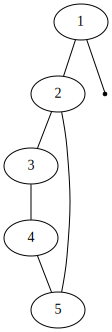

In [17]:
show(graph, result, gtsam.DefaultKeyFormatter)

The result is shown graphically in Figure
<a href="#fig:example" data-reference-type="ref" data-reference="fig:example">2</a>,
along with covariance ellipses shown in green. These covariance ellipses
in 2D indicate the marginal over position, over all possible
orientations, and show the area which contain 68.26% of the probability
mass (in 1D this would correspond to one standard deviation). The graph
shows in a clear manner that the uncertainty on pose $T_{5}$ is now
much less than if there would be only odometry measurements. The pose
with the highest uncertainty, $T_{4}$, is the one furthest away from
the unary constraint $f_{0}(T_{1})$, which is the only factor tying
the graph to a global coordinate frame.

The figure above was created using an interface that allows you to use
GTSAM from within MATLAB, which provides some excellent visualization
tools. Similar matplotlib-based visualization tools are available in
python.

Summary
-------

We briefly summarize what we learned in this section:

1.  LIDAR is a key sensor for autonomous driving

2.  Localization can be done with LIDAR, or image-based

3.  PoseSLAM: a SLAM variant using ICP pose constraints

4.  The PoseSLAM factor graph graphically shows the constraints

5.  MAP/MAP solution can be done via nonlinear optimization

6.  GTSAM is an easy way to optimize over poses in C++/MATLAB/python